### Finetuning SAM with noisy 3D neuron data

##### Setup notebook and import data

In [5]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install datasets

  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\harry\AppData\Local\Temp\pip-req-build-do7sx6zo'



  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\harry\appdata\local\temp\pip-req-build-do7sx6zo
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 526fd066dea338ba2ca08886853bd37ffd6a8aec
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [6]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tifffile
import os
import random
from scipy import ndimage
from glob import glob
import cv2
import datasets
from PIL import Image
from torch.utils.data import Dataset
from transformers import SamProcessor, SamModel, SamConfig
from torch.optim import Adam
import monai
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [8]:
# Local file directories
image_dir = "images/fin/3Dnoisyimages"
label_dir = "images/fin/3Dlabels"

# Find file paths and sort
image_paths = sorted(glob(os.path.join(image_dir, "*")))
label_paths = sorted(glob(os.path.join(label_dir, "*")))

In [9]:
images = []
labels = []

for path in image_paths:
  image = tifffile.imread(path)

  # Flatten the 3D stack by adding each 2D slice to the flattened list
  for slice_idx in range(image.shape[0]):
    images.append(image[slice_idx])

for path in label_paths:
  label = tifffile.imread(path)

  # Flatten the 3D stack by adding each 2D slice to the flattened list
  for slice_idx in range(label.shape[0]):
    labels.append(label[slice_idx])

##### Preprocess data

In [10]:
# Resize slices of image and mask to target size
target_size = (256, 256)

resized_images = []
resized_masks = []

for image in images:
  resized_image = cv2.resize(image, target_size)
  resized_images.append(resized_image)

for mask in labels:
  resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
  resized_masks.append(resized_mask)

In [11]:
# Convert list to 3D numpy array
resized_images = np.array(resized_images)
resized_masks = np.array(resized_masks)

In [12]:
resized_images.shape

(4030, 256, 256)

In [13]:
# Normalise mask values 0,1
resized_masks = resized_masks / 255

In [14]:
np.unique(resized_masks)

array([0., 1.])

In [15]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(resized_masks) if mask.max() != 0]

# Filter the image and mask arrays to keep only the non-empty masks and corresponding images
images = resized_images[valid_indices]
masks = resized_masks[valid_indices]

print("Image shape:", images.shape)
print("Mask shape:", masks.shape)

Image shape: (3510, 256, 256)
Mask shape: (3510, 256, 256)


In [16]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in images],
    "label": [Image.fromarray(mask) for mask in masks],
}

# Create the dataset using the datasets.Dataset class
dataset = datasets.Dataset.from_dict(dataset_dict)

In [17]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 3510
})

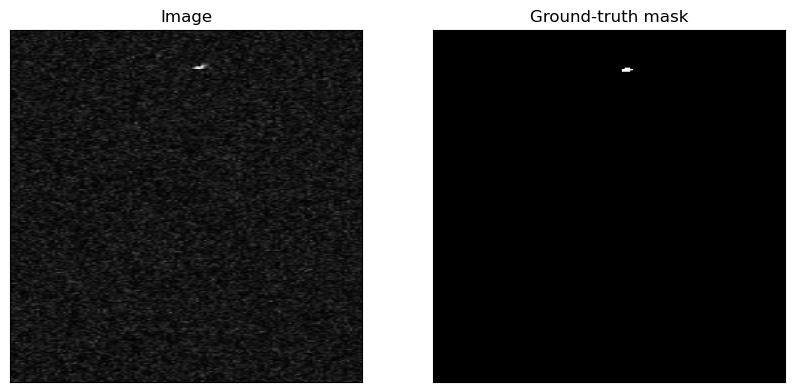

In [20]:
# Plot image and mask at random

img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the image
axes[0].imshow(np.array(example_image), cmap='gray')
axes[0].set_title("Image")

# Plot the mask
axes[1].imshow(np.array(example_mask), cmap='gray')
axes[1].set_title("Ground-truth mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()

In [21]:
# Get bounding boxes from mask which are then overlayed onto image for prompt

def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)

  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

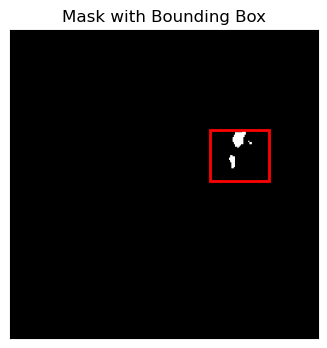

In [29]:
# Sample an item from the dataset
img_num = random.randint(0, masks.shape[0]-1)
item = dataset[img_num]

example_mask = dataset[img_num]["label"]
example_mask = np.array(example_mask)

# Get the bounding box from the mask
bbox = get_bounding_box(example_mask)

# Plot the image and mask with the bounding box
fig, ax = plt.subplots(figsize=(8, 4))

# Show the mask
ax.imshow(example_mask, cmap='gray')

# Create a rectangle patch for the bounding box
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')

# Add the rectangle to the plot
ax.add_patch(rect)

# Set the title and hide axis ticks
ax.set_title("Mask with Bounding Box")
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [30]:
# Split into train and test sets
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.1, random_state=42)

train_set = torch.utils.data.Subset(dataset, train_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

##### Setup dataset class

In [31]:
class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]

    # Convert to numpy array
    image = np.array(image)

    # Check if the image is greyscale and if so convert to RGB
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)
        image = np.repeat(image, 3, axis=2)

    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [32]:
# Initialise processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [33]:
# Create train and test instances of SAMDataset
train_dataset = SAMDataset(dataset=train_set, processor=processor)
test_dataset = SAMDataset(dataset=test_set, processor=processor)

In [34]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [35]:
# Create a DataLoader instance for the training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

In [36]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [37]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [38]:
# Metric functions

def iou_score(segmentation, gt):
    """A function to compute IoU"""
    intersection = (segmentation*gt).sum()
    union = segmentation.sum() + gt.sum() - intersection
    score = intersection / union
    return score

def dice_score(segmentation, gt):
    """A function to compute Dice coefficient"""
    intersection = (segmentation*gt).sum()
    score = (2. *intersection) / (segmentation.sum() + gt.sum())
    return score

##### Setup training

In [39]:
# Load the model
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Ensure we only fine-tune the mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [40]:
# Initialise the optimiser and select hyperparameters
optimiser = Adam(model.mask_decoder.parameters(), lr=1e-4, weight_decay=0)

# Initalise DiceLoss function
seg_loss = monai.losses.DiceLoss(sigmoid=True)

In [41]:
# Define number of epochs
num_epochs = 20

# Set model to cuda device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

training_losses = []
test_losses_score = []
dice_scores_test = []
iou_scores_test = []

# Start training loop
for epoch in range(num_epochs):
  # Put model into train mode
  model.train()

  epoch_losses = []

  # Loop for each batch in training data
  for batch in tqdm(train_dataloader):
    # Forward pass for each batch input upscaled image and bounding box data into model to get output and place in device memory
    outputs = model(pixel_values=batch["pixel_values"].to(device),
                    input_boxes=batch["input_boxes"].to(device),
                    multimask_output=False)

    # Outputs logits of segmentation mask
    segmentation_logit = outputs.pred_masks.squeeze(1)

    # Load mask from batch and convert to same dtype and size as segmentation
    gt_mask = batch["ground_truth_mask"].unsqueeze(1).float().to(device)

    # Calculate loss (Diceloss)
    loss = seg_loss(segmentation_logit, gt_mask)

    # Backward pass
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    # Append loss for batch to epoch loss list
    epoch_losses.append(loss.item())

  # Calculate mean loss for epoch
  training_losses.append(mean(epoch_losses))
  print(f"Epoch: {epoch+1}, Loss: {mean(epoch_losses)}")

  # Put model into eval mode
  model.eval()

  # Instantiate empty lists for metrics
  test_losses = []
  dice_scores = []
  iou_scores = []

  # Ensure no weights are altered
  with torch.no_grad():
    for batch in tqdm(test_dataloader):

      # Forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # Compute loss
      segmentation_logit = outputs.pred_masks.squeeze(1)
      gt_mask = batch["ground_truth_mask"].unsqueeze(1).float().to(device)

      loss = seg_loss(segmentation_logit, gt_mask)

      # Append loss for batch to epoch loss list
      test_losses.append(loss.item())

      # Convert logits with sigmoid function
      segmentation_prob = torch.sigmoid(segmentation_logit)

      # Convert probability map to binary
      predicted_mask_bin = ((segmentation_prob) > 0.5).float()

      # Compute Dice and IoU metrics
      dice = dice_score(predicted_mask_bin, gt_mask)
      iou = iou_score(predicted_mask_bin, gt_mask)

      # Append metrics to lists
      dice_scores.append(dice.item())
      iou_scores.append(iou.item())

    test_losses_score.append(mean(test_losses))
    iou_scores_test.append(mean(iou_scores))
    dice_scores_test.append(mean(dice_scores))

    print(f"Epoch: {epoch+1}, test loss: {mean(test_losses)}, test iou: {mean(iou_scores)}, test dice: {mean(dice_scores)}")

100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:23<00:00,  1.83it/s]


Epoch: 1, Loss: 0.6309451472155655


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 1, test loss: 0.632345378737558, test iou: 0.2657609923785044, test dice: 0.4029794149418277


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:28<00:00,  1.82it/s]


Epoch: 2, Loss: 0.6183399176484422


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 2, test loss: 0.6321643697605892, test iou: 0.2602562592814634, test dice: 0.3968558929521929


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:28<00:00,  1.82it/s]


Epoch: 3, Loss: 0.6235139922439298


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 3, test loss: 0.6204769333655183, test iou: 0.2689119240914641, test dice: 0.4062192996074869


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:27<00:00,  1.82it/s]


Epoch: 4, Loss: 0.6185433663144896


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 4, test loss: 0.6261650195175951, test iou: 0.2723124232513576, test dice: 0.41178848850540817


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:27<00:00,  1.82it/s]


Epoch: 5, Loss: 0.6080372710393954


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 5, test loss: 0.6242485877803781, test iou: 0.25981222274078225, test dice: 0.39385971522212704


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:27<00:00,  1.82it/s]


Epoch: 6, Loss: 0.6058983052078681


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 6, test loss: 0.6187747097150846, test iou: 0.25079526360654697, test dice: 0.38299008774761617


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:27<00:00,  1.82it/s]


Epoch: 7, Loss: 0.6024522680459143


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 7, test loss: 0.6069614450362596, test iou: 0.27233170002000406, test dice: 0.4120623074598949


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:27<00:00,  1.82it/s]


Epoch: 8, Loss: 0.6054432882726947


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 8, test loss: 0.6333201779899272, test iou: 0.22750485966786405, test dice: 0.34839847270103


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:26<00:00,  1.82it/s]


Epoch: 9, Loss: 0.6022482849185979


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 9, test loss: 0.6061626864089207, test iou: 0.26977575405246834, test dice: 0.4100765022131699


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:27<00:00,  1.82it/s]


Epoch: 10, Loss: 0.6010559278764303


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 10, test loss: 0.6135951065543023, test iou: 0.27590901154326275, test dice: 0.4149709505304186


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:27<00:00,  1.82it/s]


Epoch: 11, Loss: 0.6007478083613552


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 11, test loss: 0.6127957508645274, test iou: 0.26296775231391867, test dice: 0.39922299348241225


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:27<00:00,  1.82it/s]


Epoch: 12, Loss: 0.6024976629810997


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 12, test loss: 0.6245058192448183, test iou: 0.27512539592994883, test dice: 0.41767038917168975


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:27<00:00,  1.82it/s]


Epoch: 13, Loss: 0.5991523333176781


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 13, test loss: 0.6100439524108713, test iou: 0.2735713150415739, test dice: 0.4132430162492462


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:28<00:00,  1.82it/s]


Epoch: 14, Loss: 0.6021047878491728


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 14, test loss: 0.6159077566117048, test iou: 0.26416393782181496, test dice: 0.40002634046091273


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:27<00:00,  1.82it/s]


Epoch: 15, Loss: 0.599387697818913


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 15, test loss: 0.6074671293185516, test iou: 0.27088649182538077, test dice: 0.40894943064036354


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:28<00:00,  1.82it/s]


Epoch: 16, Loss: 0.5941916873183432


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 16, test loss: 0.6155624790963802, test iou: 0.253418175577694, test dice: 0.38472224022685125


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:28<00:00,  1.82it/s]


Epoch: 17, Loss: 0.5965519069682194


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 17, test loss: 0.6097331187603149, test iou: 0.2819626300003041, test dice: 0.4261378155894239


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:28<00:00,  1.82it/s]


Epoch: 18, Loss: 0.5976500770336465


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 18, test loss: 0.6147565985606476, test iou: 0.26403124254747207, test dice: 0.4015826686412435


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:28<00:00,  1.82it/s]


Epoch: 19, Loss: 0.6042504949282996


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]


Epoch: 19, test loss: 0.6256644690239971, test iou: 0.27190287663093343, test dice: 0.4117186275649477


100%|██████████████████████████████████████████████████████████████████████████████| 1580/1580 [14:28<00:00,  1.82it/s]


Epoch: 20, Loss: 0.6082718675083751


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [01:33<00:00,  1.88it/s]

Epoch: 20, test loss: 0.6082835669883273, test iou: 0.28035533731930296, test dice: 0.4241763285403563


##### Show metrics

In [42]:
output_dir = "output/noisy/3d_sam_noisy_metrics"

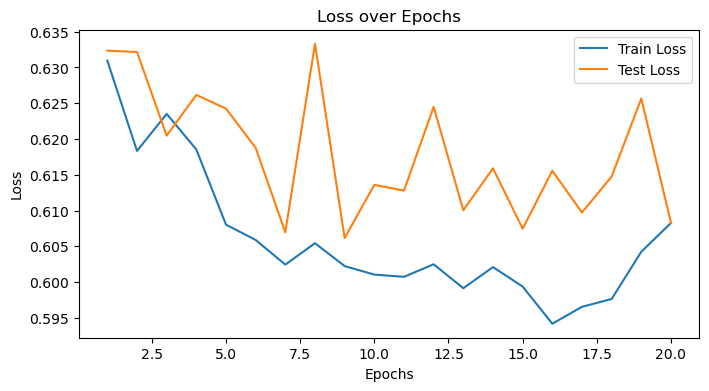

In [43]:
# Plot loss metrics

plt.figure(figsize=(8, 4))

epochs = range(1, num_epochs + 1)

plt.plot(epochs, training_losses, label='Train Loss')
plt.plot(epochs, test_losses_score, label='Test Loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.savefig(f"{output_dir}/noisy_3d_SAM_loss_results.png")
plt.show()

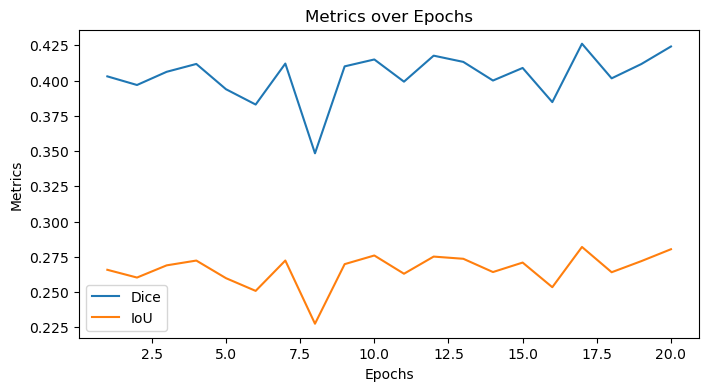

In [44]:
# Plot evaluation metrics

plt.figure(figsize=(8,4))

epochs = range(1, num_epochs + 1)

plt.plot(epochs, dice_scores_test, label="Dice")
plt.plot(epochs, iou_scores_test, label='IoU')

plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Metrics over Epochs")
plt.legend()

plt.savefig(f"{output_dir}/noisy_3d_SAM_metrics_results.png")
plt.show()

In [45]:
# Save the model
torch.save(model.state_dict(), "models/noisy_3D_SAM.pth")

##### Inference

In [46]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_model = SamModel(config=model_config)

# Update the model by loading the weights from saved file.
my_model.load_state_dict(torch.load("models/noisy_3D_SAM.pth"))

C:\Users\harry\AppData\Local\Temp\ipykernel_12284\2215532609.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_model.load_state_dict(torch.load("models/noisy_3D_SAM.pth

<All keys matched successfully>

In [47]:
# set the model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
my_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [48]:
# Import image stack for inference
img_dir = 'images/fin/inf_set/3Dnoisyimages'
lab_dir = 'images/fin/inf_set/3Dlabels'

image_paths = sorted(glob(os.path.join(img_dir, "*.tif")))
label_paths = sorted(glob(os.path.join(lab_dir, "*.tif")))

In [49]:
inf_images = []
inf_masks = []

for image_path, label_path in zip(image_paths, label_paths):
    inf_image = tifffile.imread(image_path)
    inf_label = tifffile.imread(label_path)

    target_size = (256, 256)
    
    resized_image_stack = []
    resized_mask_stack = []

    for image in inf_image:
        resized_image = cv2.resize(image, target_size)
        resized_image_stack.append(resized_image)

    for mask in inf_label:
        resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        resized_mask_stack.append(resized_mask)

    # Convert list to 3D numpy array
    resized_image_stack = np.array(resized_image_stack)
    resized_mask_stack = np.array(resized_mask_stack)

    # Normalize mask values 0,1
    resized_mask_stack = resized_mask_stack / 255

    # Filter out empty masks
    valid_indices = [i for i, mask in enumerate(resized_mask_stack) if mask.max() != 0]
    filtered_images = resized_image_stack[valid_indices]
    filtered_masks = resized_mask_stack[valid_indices]

    # Append the processed 3D stack to the list
    inf_images.append(filtered_images)
    inf_masks.append(filtered_masks)

print(f"Number of image stacks loaded: {len(inf_images)}")
print(f"Shape of first image stack: {inf_images[0].shape}")


Number of image stacks loaded: 4
Shape of first image stack: (93, 256, 256)


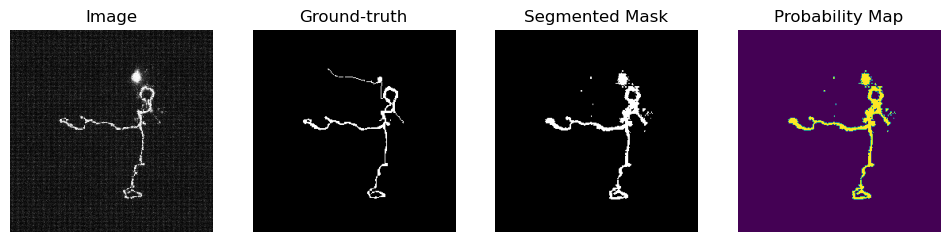

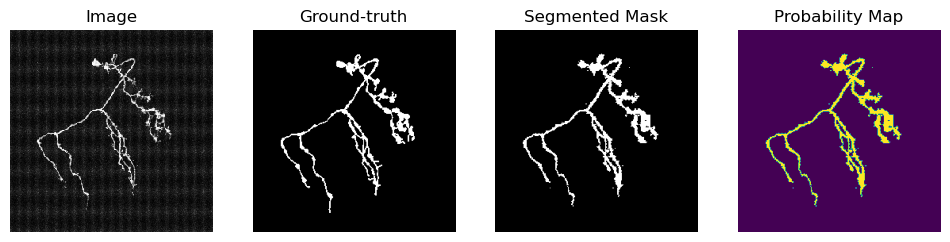

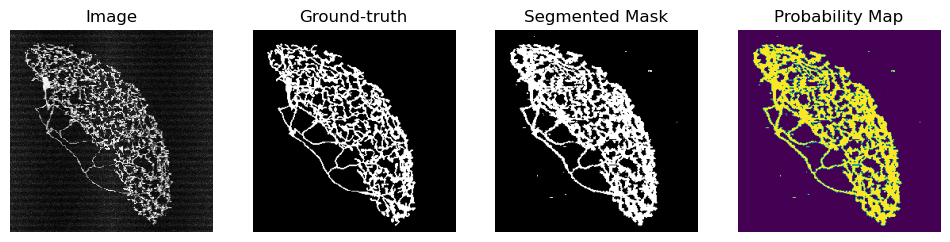

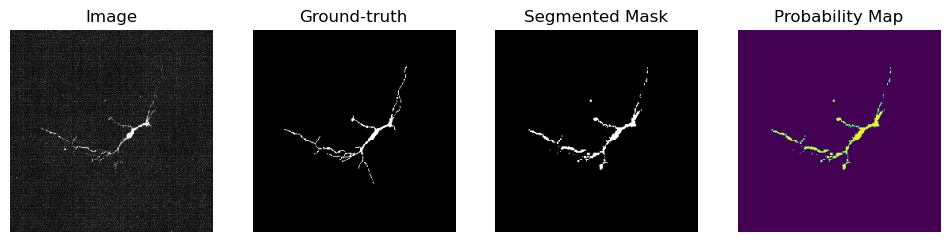

In [52]:
output_dir_fig = "output/noisy/3d_sam_noisy_inf"

for idx, (image_stack, mask_stack) in enumerate(zip(inf_images, inf_masks)):
    # Run inference on the selected stack slice by slice
    segmented_slices = []
    probability_slices = []

    for i in range(image_stack.shape[0]):
        # Get i-th slice from the selected 3D stack
        test_image = np.array(image_stack[i])

        # Convert to RGB if greyscale
        if test_image.ndim == 2:
            test_image = np.expand_dims(test_image, axis=-1)
            test_image = np.repeat(test_image, 3, axis=2)

        # Get box prompt from mask
        ground_truth_mask = np.array(mask_stack[i])
        prompt = get_bounding_box(ground_truth_mask)

        # Prepare image + box prompt for the model
        inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

        # Move the input tensor to the GPU
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Put into inference mode
        my_model.eval()

        # Forward pass with no changing of weights etc.
        with torch.no_grad():
            outputs = my_model(**inputs, multimask_output=False)

        # Apply sigmoid
        segmentation_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
        # Convert soft mask to hard mask
        segmentation_prob = segmentation_prob.cpu().numpy().squeeze()
        bin_segmentation = (segmentation_prob > 0.5).astype(np.uint8)

        probability_slices.append(segmentation_prob)
        segmented_slices.append(bin_segmentation)

    # Stack all slices into 3D volumes
    probability_volume = np.stack(probability_slices, axis=0)
    segmented_volume = np.stack(segmented_slices, axis=0)

    # Create MIPs for 2D plotting
    image_mip = np.max(image_stack, axis=0)
    gt_mip = np.max(mask_stack, axis=0)
    segmented_mip = np.max(segmented_volume, axis=0)
    probability_mip = np.max(probability_volume, axis=0)

    # Plot the images
    fig, axes = plt.subplots(1, 4, figsize=(12, 5))

    # Plot the image
    axes[0].imshow(np.array(image_mip), interpolation="none", cmap="gray")
    axes[0].set_title("Image")
    axes[0].axis("off")

    # Plot the ground-truth mask
    axes[1].imshow(gt_mip, cmap="gray")
    axes[1].set_title("Ground-truth")
    axes[1].axis("off")

    # Plot the segmented mask
    axes[2].imshow(segmented_mip, cmap="gray")
    axes[2].set_title("Segmented Mask")
    axes[2].axis("off")

    # Plot the probability map
    im = axes[3].imshow(probability_mip, cmap="viridis", vmin=0, vmax=1)
    axes[3].set_title("Probability Map")
    axes[3].axis("off")

    plt.savefig(f"{output_dir_fig}/inference_results_stack{idx}.png", bbox_inches="tight", pad_inches=1)
    plt.show()